### 라벨 스무딩 적용 여부 비교

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor

#### 사용자 정의 손실함수 (라벨 스무딩 적용 크로스 엔트로피)

In [2]:
class LabelSmoothingLoss(nn.Module) : # 사용자 정의 손실 함수
    def __init__(self, num_classes, smoothing=0.0) :
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes # 분류 문제 : 클래스 개수
        self.smoothing = smoothing # 라벨 적용되는 스무딩 정도 제어 값 -> 기본 0.0 스무딩 적용 x
        self.confidence = 1.0 - smoothing # smoothing 보정값 (정답에 대한 신뢰도 점수)
    
    def forward(self, pred, target) : # pred : 예측값, target : 정답
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1) # 원핫인코딩 텐서 생성
        # 원핫인코딩 텐서에서 라벨 스무딩을 적용 -> 신뢰도 점수
        smooth_label = one_hot * self.confidence + (1 - one_hot) * self.smoothing / (self.num_classes - 1)
        # 스무딩 처리된 라벨과 예측 확률간 교차 엔트로피 사용해서 loss계산 : log_softmax 확률과 라벨 스무딩 요소 곱을 통해 수행 
        loss = torch.sum(-smooth_label * torch.log_softmax(pred, dim=1), dim=1)
        return torch.mean(loss) # 평균 손실 구해주고 반환

#### 모델 정의

In [3]:
class MyModel(nn.Module) :
    def __init__(self) :
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

#### 데이터셋 로드 및 전처리

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=ToTensor(), download=False)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=ToTensor(), download=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 모델 정의

In [5]:
model = MyModel()
print(model)

MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#### 옵티마이저 설정, loss 함수 설정

In [6]:
# 옵티마이저 설정
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 손실 함수 정의
num_classes = 10
smoothing = 0.2
no_smoothing_criterion = LabelSmoothingLoss(num_classes, smoothing=0.0)
smoothing_criterion = LabelSmoothingLoss(num_classes, smoothing)

#### 학습 루프

In [7]:
num_epochs = 20 
train_losses_no_smoothing = []
train_losses_smoothing = []

for epoch in range(num_epochs) :
    losses_no_smoothing = 0.0
    losses_smoothing = 0.0
    for images, labels in train_dataloader :
        optimizer.zero_grad()
        # 라벨 스무딩 적용하지 않는 경우
        outputs_no_smoothing = model(images)
        loss_no_smoothing = no_smoothing_criterion(outputs_no_smoothing, labels)
        loss_no_smoothing.backward()
        optimizer.step()
        losses_no_smoothing += loss_no_smoothing.item()

        # 라벨 스무딩 적용하는 경우
        outputs_smoothing = model(images)
        loss_smoothing = smoothing_criterion(outputs_smoothing, labels)
        loss_smoothing.backward()
        optimizer.step()
        losses_smoothing += loss_smoothing.item()
    # 에포크마다 손실 기록
    train_losses_no_smoothing.append(losses_no_smoothing / len(train_dataloader))
    train_losses_smoothing.append(losses_smoothing / len(train_dataloader))

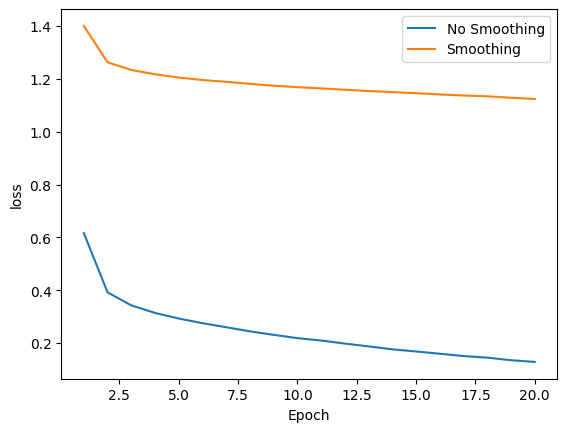

In [8]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses_no_smoothing, label='No Smoothing')
plt.plot(epochs, train_losses_smoothing, label='Smoothing')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()